In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.9 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#ML Libraries
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import xgboost
from xgboost import XGBClassifier
from xgboost import cv

In [4]:
train_file = "/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/training.csv"
test_file = "/content/drive/MyDrive/Grad School-Files/Job Search/WiDS 2024/test.csv"

In [5]:
#Import training and test data
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# Helper functions

In [6]:
#Helper function to remove columns with low variance
def remove_low_var(df, threshold=0.1):
  df_copy = df.copy()
  rem = []
  for col in df_copy.columns:
    if df_copy[col].std() < threshold:
          rem.append(col)
          df_copy = df_copy.drop([col], axis=1)
    print('Columns removed: ', rem)
    return df

#Helper function to remove columns with high correlations
def remove_corr(data):

  df_copy = data.copy()
  #remove correlations
  numerical_features = df_copy.select_dtypes('number').columns
  num_feature = [col for col in numerical_features]
  drop_columns = []
  # Create correlation matrix
  corr_matrix = df_copy[num_feature].corr().abs()
  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

  # Find index of feature columns with correlation greater than 0.98
  to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
  df_copy.drop(to_drop, inplace=True, axis=1)
  print('Columns removed: ', to_drop)
  return df_copy

#Helper function to split data
def data_split(scaler_func, data, test_size=0.33):

  #Separate features from target
  X = data.drop('DiagPeriodL90D', axis = 1).values
  y = data['DiagPeriodL90D'].values

  #Scale and standardize the data
  #scaling
  scaler = scaler_func
  train = scaler.fit_transform(X)

  #Split data into training and test sets
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

  return X_train, X_val, y_train, y_val

#Helper functions that runs model and prints stats if get_stats=True
def run_model(scaler, data, clf, plot=False):

  X_train, X_val, y_train, y_val = data_split(scaler, data)
  model = clf
  model.fit(X_train,y_train)
  y_pred = model.predict(X_val)
  # Calculate and print individual metrics
  accuracy = accuracy_score(y_val,y_pred)
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  f1 = f1_score(y_val, y_pred)

  if plot:
    model_stats(y_val, y_pred)

  return y_pred, accuracy, precision, recall, f1, auc

#Helper function cross validate predictive model
def model_cross_val(scaler_func, clf,data):
  #Separate features from target
  X = data.drop('DiagPeriodL90D', axis = 1).values
  y = data['DiagPeriodL90D'].values

  #Scale and standardize the data
  scaler = scaler_func
  train = scaler.fit_transform(X)

  kfold = KFold(n_splits=5)
  results = cross_val_score(clf, X, y, cv=kfold)
  return results.mean()

#Helper function that prints stats
def model_stats(y_val, y_pred):
  # Print confusion matrix
  print("Confusion Matrix:")
  print(confusion_matrix(y_val, y_pred))

  # Evaluate the model using classification report
  print("\nClassification Report:")
  print(classification_report(y_val, y_pred))

  print("\nIndividual Metrics:")
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred))
  disp.plot()
  plt.show()

  # Calculate AUC
  auc = roc_auc_score(y_val, y_pred)
  print("AUC:", auc)

  # Plot ROC curve
  fpr, tpr, thresholds = roc_curve(y_val, y_pred)
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
  plt.plot([0, 1], [0, 1], 'k--', label='Random')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()

# Problem Statement

Based on the provided dataset which consists of patients information (age, race, BMI, zip code, breast cancer diagnosis code, metastatic cancer diagnosis code, metastatic cancer treatments, etc.), their geo-demographic data (income, education, rent, race, poverty, …etc), as well as toxic air quality data (Ozone, PM25 and NO2), predict the likelihood of the patient’s Diagnosis Period being less than 90 days .



# Obtain basic information about the dataset

In [7]:
# Print the shape of training and test data
print(train.info())
print("Shape of training data set: ", train.shape)
print("Shape of test data set: ", test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

The dataset has 83 columns and 12905 total entries. Note that there are two sets of information, patient level data and demographics data. So, let's split the dataset into two: patient level data and demographic data

In [8]:
#Remove columns where over half the values are null
null_values = pd.DataFrame(train.isna().sum(), columns=['null_vals']).reset_index()
null_values_sig = null_values[null_values['null_vals'] >= len(train)/2]

train = train.drop(null_values_sig['index'], axis='columns')
test = test.drop(null_values_sig['index'], axis='columns')
print(train.shape)
print(test.shape)

(12906, 80)
(5792, 79)


In [9]:
# Remove rows with more than 2 null values
train.drop(train[train.isnull().sum(axis=1)>2].index,axis=0,inplace=True)
print(train.shape)

(12823, 80)


In [10]:
#Redefine NaN payer type as no insurance info
train['payer_type'] = train['payer_type'].fillna('UNDEFINED')
test['payer_type'] = train['payer_type'].fillna('UNDEFINED')

In [11]:
train = train.drop(['patient_race','breast_cancer_diagnosis_desc', 'patient_gender'] , axis=1)
test = test.drop(['patient_race','breast_cancer_diagnosis_desc', 'patient_gender'] , axis=1)
print(train.shape)
print(test.shape)

(12823, 77)
(5792, 76)


# Encode categorical features

To prepare categorical features for building a predictive model, the features first need to be encoded to input into the model. In this case, we use a one-hot encoding scheme to encode the categorical variables.

In [12]:
#Get only categorical vars
train_cat = train.select_dtypes(include ='object')
test_cat = test.select_dtypes(include ='object')
cat_columns = train_cat.columns
cat_columns_test = test_cat.columns

#One hot encode variables
train_cat_dummies = pd.get_dummies(train_cat)
test_cat_dummies = pd.get_dummies(test_cat)

#Merge dummies with training data
train_encoded = pd.concat([train, train_cat_dummies], axis=1)
test_encoded = pd.concat([test, test_cat_dummies], axis=1)

#Drop categorical columns
train_encoded = train_encoded.drop(cat_columns, axis=1)
test_encoded = test_encoded.drop(cat_columns, axis=1)

In [13]:
print("Shape of training data set: ", train_encoded.shape)
print("Shape of test data set: ", test_encoded.shape)

Shape of training data set:  (12823, 229)
Shape of test data set:  (5792, 215)


In [14]:
# Get missing columns in the training test
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_encoded[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_encoded = test_encoded[train_encoded.columns]

#Deal with missing values

In [15]:
null_vals = pd.DataFrame(train_encoded.isna().sum())
null_vals.head(10)

,0
patient_id,0
patient_zip3,0
patient_age,0
population,0
density,0
age_median,0
age_under_10,0
age_10_to_19,0
age_20s,0
age_30s,0


No null values in this dataframe

# Setup the training and validation data

In [16]:
#Separate features from target
X = train_encoded.drop('DiagPeriodL90D', axis = 1).values
y = train_encoded['DiagPeriodL90D'].values

#Scale and standardize the data
#scaling
scaler = StandardScaler()
train = scaler.fit_transform(X)

In [17]:
#Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# Build out Models

## XGBoost

Build a simple XGBoost (boosted tree) model

In [18]:
xgboost_model = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=10)
xgboost_model.fit(X_train,y_train)
y_pred = xgboost_model.predict(X_val)

In [19]:
# Convert probabilities to binary predictions using a threshold of 0.5
y_binary_predictions = (y_pred >= 0.5).astype(int)
print(y_binary_predictions)

[1 1 1 ... 1 1 1]


Confusion Matrix:
[[ 915  645]
 [ 337 2335]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.59      0.65      1560
           1       0.78      0.87      0.83      2672

    accuracy                           0.77      4232
   macro avg       0.76      0.73      0.74      4232
weighted avg       0.76      0.77      0.76      4232


Individual Metrics:
Accuracy: 0.7679584120982986
Precision: 0.7835570469798657
Recall: 0.873877245508982
F1 Score: 0.8262561924982308


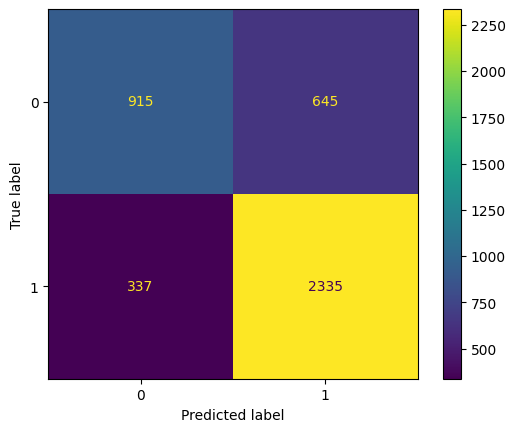

In [20]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_binary_predictions))

# Evaluate the model using classification report
print("\nClassification Report:")
print(classification_report(y_val, y_binary_predictions))

# Calculate and print individual metrics
accuracy = accuracy_score(y_val,y_binary_predictions)
precision = metrics.precision_score(y_val, y_binary_predictions)
recall = metrics.recall_score(y_val, y_binary_predictions)
f1 = metrics.f1_score(y_val, y_binary_predictions)

print("\nIndividual Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_binary_predictions))
disp.plot()
plt.show()

AUC: 0.7302078535237219


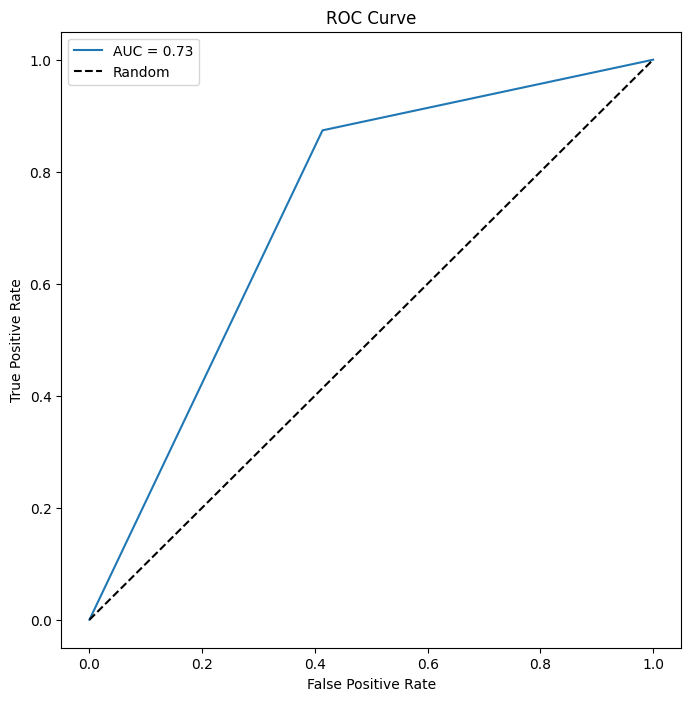

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
# Assuming y_binary_predictions are the predicted binary labels for your test set

# Calculate AUC
auc = roc_auc_score(y_val, y_binary_predictions)
print("AUC:", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_binary_predictions)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Observations



*   From the confusion matrix, we see that this classifier accurately classifies over the datapoints as true positives. The number of false positives are almost double the number of false negatives. So, there is bias in the classifier, which maybe due to the imbalance in the dataset (more positives than negatives)

*   Precision answers the question "of all the instances the model predicted as positive, how many were actually positive?" In this case, the model classified 78.3% of actual positives as positives

* Recall answers the question, “of all the instances that truly belong to a certain class, how many did the model correctly identify?” In this case, the model classified 87.4% of instances into their correct classes

* The AUC curve tells us that the classifier performs better than random. A rough rule of thumb is that the accuracy of tests with AUCs between 0.50 and 0.70 is low; between 0.70 and 0.90, the accuracy is moderate; and it is high for AUCs over 0.90. In this case, the classifier has moderate accuracy

In [24]:
#XGBClassifier
xgboost_clf = XGBClassifier(random_state=42)
xgboost_clf.fit(X_train, y_train)
y_pred = xgboost_clf.predict(X_val)

Confusion Matrix:
[[ 887  673]
 [ 237 2435]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.57      0.66      1560
           1       0.78      0.91      0.84      2672

    accuracy                           0.78      4232
   macro avg       0.79      0.74      0.75      4232
weighted avg       0.79      0.78      0.78      4232


Individual Metrics:
Accuracy: 0.7849716446124764
Precision: 0.7834620334620335
Recall: 0.9113023952095808
F1 Score: 0.8425605536332179


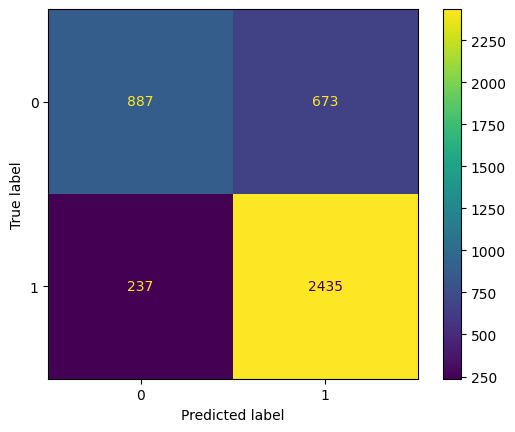

In [25]:
# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Evaluate the model using classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Calculate and print individual metrics
accuracy = accuracy_score(y_val,y_pred)
precision = metrics.precision_score(y_val, y_pred)
recall = metrics.recall_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)

print("\nIndividual Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_pred))
disp.plot()
plt.show()

AUC: 0.7302078535237219


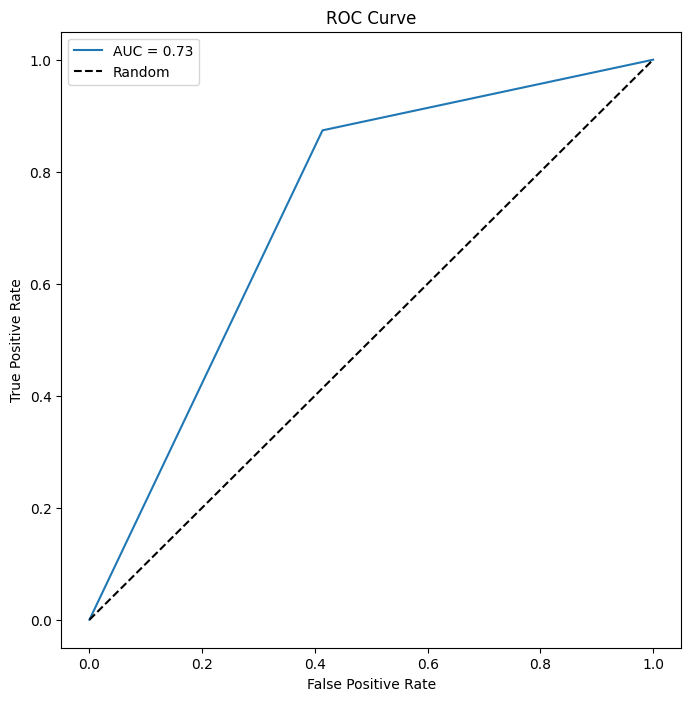

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
# Assuming y_binary_predictions are the predicted binary labels for your test set

# Calculate AUC
auc = roc_auc_score(y_val, y_binary_predictions)
print("AUC:", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_binary_predictions)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

*   From the confusion matrix, we see that this classifier accurately classifies over the datapoints as true positives. The number of false positives are almost three times the number of false negatives. So, there is bias in the classifier, which maybe due to the imbalance in the dataset (more positives than negatives). Also, in this case, the classifier is further skewed towards correctly identifying the positives.

*   Precision answers the question "of all the instances the model predicted as positive, how many were actually positive?" In this case, the model classified 78.3% of actual positives as positives

* Recall answers the question, “of all the instances that truly belong to a certain class, how many did the model correctly identify?” In this case, the model classified 91.1% of instances into their correct classes

* The AUC curve tells us that the classifier performs better than random. A rough rule of thumb is that the accuracy of tests with AUCs between 0.50 and 0.70 is low; between 0.70 and 0.90, the accuracy is moderate; and it is high for AUCs over 0.90. In this case, the classifier has moderate accuracy

* We see that the accuracy for this is lower than the previous and there is a slightly bigger gap between precision and recall.

# Feature Engineering

There are multiple ways to pick out features

1. Remove correlations
2. Remove columns with low variance
3. Lasso regression

Let's try each with XGBclassifier

## 1. Remove correlations

Features that are highly correlated often have redundant information in them, so we can try to remove them

In [27]:
#Make copy of original dataset
train_encoded_corr = remove_corr(train_encoded)
train_encoded_corr.head(10)

Columns removed:  ['female', 'housing_units', 'Division_Middle Atlantic']


,patient_id,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,...,Region_South,Region_West,Division_East North Central,Division_East South Central,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
0,475714,924,84,31437.750000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,...,0,1,0,0,0,0,1,0,0,0
1,349367,928,62,39121.878790,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,...,0,1,0,0,0,0,1,0,0,0
2,138632,760,43,21996.683330,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,...,1,0,0,0,0,0,0,0,0,1
3,617843,926,45,32795.325580,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,...,0,1,0,0,0,0,1,0,0,0
4,817482,836,55,10886.260000,116.886000,43.473469,10.824000,13.976000,9.492000,10.364000,...,0,1,0,0,1,0,0,0,0,0
5,111545,141,66,5643.771429,219.362857,45.180000,8.511429,14.857143,11.088571,9.754286,...,0,0,0,0,0,0,0,0,0,0
6,914071,900,51,36054.117650,5294.330882,36.653846,9.761538,11.267692,17.233846,17.441538,...,0,1,0,0,0,0,1,0,0,0
7,479368,619,60,3404.100000,25.733333,42.790000,11.983333,13.256667,9.573333,12.400000,...,0,0,1,0,0,0,0,0,0,0
9,155485,617,64,4435.320755,68.001887,41.300000,12.835849,13.681132,10.524528,11.937736,...,0,0,1,0,0,0,0,0,0,0
10,875977,488,67,8101.000000,246.281013,40.278205,11.045570,14.768354,13.384810,11.467089,...,0,0,1,0,0,0,0,0,0,0


## 2. Remove columns with low variance

Columns that have low variance do not add a lot of information either because they are not really changing



In [28]:
train_encoded_var = remove_low_var(train_encoded)
train_encoded_var.head(10)

Columns removed:  []


,patient_id,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,...,Region_West,Division_East North Central,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
0,475714,924,84,31437.750000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,...,1,0,0,0,0,0,1,0,0,0
1,349367,928,62,39121.878790,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,...,1,0,0,0,0,0,1,0,0,0
2,138632,760,43,21996.683330,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,...,0,0,0,0,0,0,0,0,0,1
3,617843,926,45,32795.325580,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,...,1,0,0,0,0,0,1,0,0,0
4,817482,836,55,10886.260000,116.886000,43.473469,10.824000,13.976000,9.492000,10.364000,...,1,0,0,0,1,0,0,0,0,0
5,111545,141,66,5643.771429,219.362857,45.180000,8.511429,14.857143,11.088571,9.754286,...,0,0,0,1,0,0,0,0,0,0
6,914071,900,51,36054.117650,5294.330882,36.653846,9.761538,11.267692,17.233846,17.441538,...,1,0,0,0,0,0,1,0,0,0
7,479368,619,60,3404.100000,25.733333,42.790000,11.983333,13.256667,9.573333,12.400000,...,0,1,0,0,0,0,0,0,0,0
9,155485,617,64,4435.320755,68.001887,41.300000,12.835849,13.681132,10.524528,11.937736,...,0,1,0,0,0,0,0,0,0,0
10,875977,488,67,8101.000000,246.281013,40.278205,11.045570,14.768354,13.384810,11.467089,...,0,1,0,0,0,0,0,0,0,0


## 3. Use Lasso Regression to identify important features

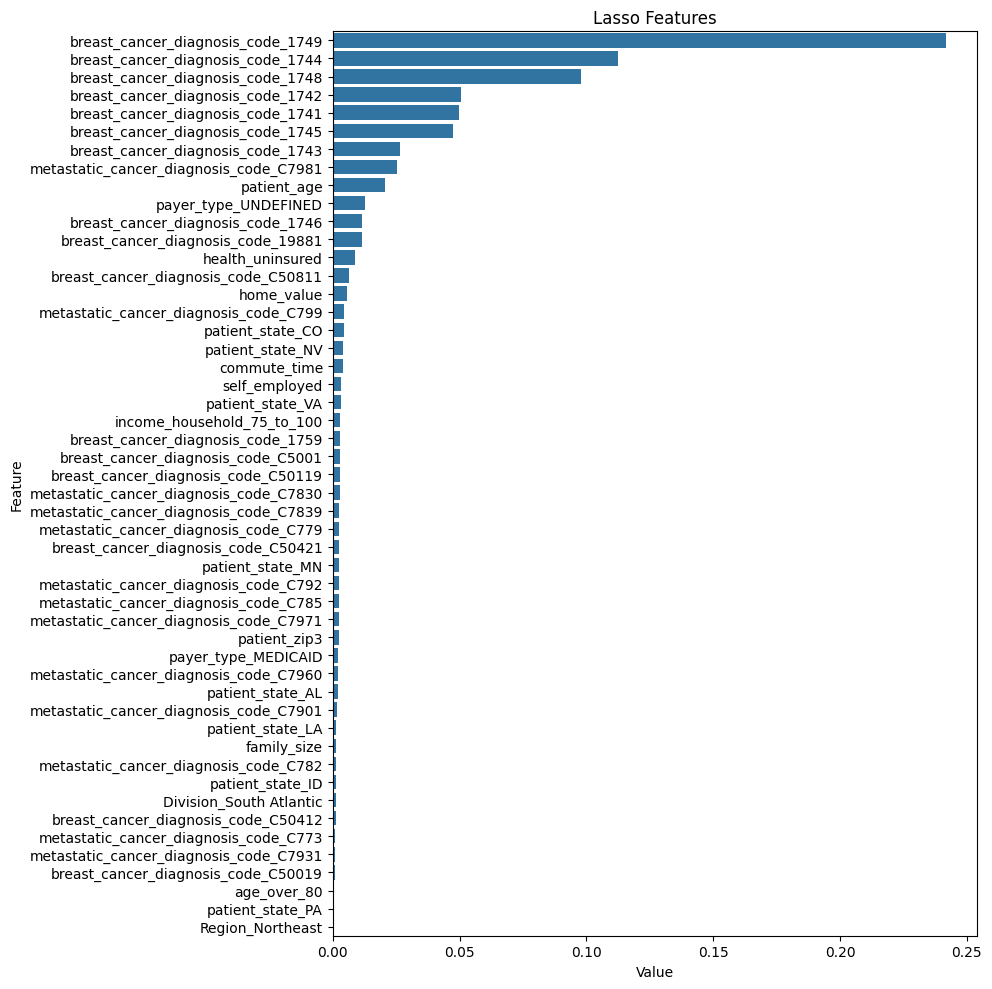

In [29]:
from sklearn.linear_model import LassoCV

y = train_encoded["DiagPeriodL90D"]
X_ = train_encoded.drop(["DiagPeriodL90D"],axis =1)

## Standardize the data

scaler = StandardScaler()
X = scaler.fit_transform(X_)
cols = X_.columns

#Train a Lasso regressor
lasso = LassoCV().fit(X, y)
#Find important features
importance = np.abs(lasso.coef_)
#Feature names correspond with columns
feature_names = np.array(cols)

#Sort features by importaance
feat_ind = np.argsort(importance)[::-1]
#totlasso = 20
feature_imp = pd.DataFrame(columns=['Value','Feature'])
feature_imp.loc[:,'Value'] = importance
feature_imp.loc[:,'Feature'] = cols

feature_imp = pd.DataFrame(sorted(zip(importance, cols)), columns=['Value','Feature'])
data_feat = feature_imp.sort_values(by="Value", ascending=False)
#data_feat = data_feat.iloc[0:30, :]
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=data_feat[0:50])
plt.title('Lasso Features')
plt.tight_layout()
plt.show()

# Compare performance using XGBClassifier

In [30]:
clf = XGBClassifier(random_state=42)
scaler = StandardScaler()

#Model after removing correlations
y_pred, accuracy, precision, recall, f1, auc = run_model(scaler, train_encoded_corr, clf)

In [31]:
clf = XGBClassifier(random_state=42)
scaler = StandardScaler()

#Model after removing correlations
y_pred, accuracy, precision, recall, f1, auc = run_model(scaler, train_encoded_var, clf)

# Select important features

In [32]:
# Select the top 50 important features
cols = data_feat.Feature[0:50]
train_feat = pd.DataFrame(train_encoded, columns=data_feat.Feature[0:50])
train_feat = pd.concat([train_feat, train_encoded['DiagPeriodL90D']], axis = 1)
train_feat.head(10)

,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1748,breast_cancer_diagnosis_code_1742,breast_cancer_diagnosis_code_1741,breast_cancer_diagnosis_code_1745,breast_cancer_diagnosis_code_1743,metastatic_cancer_diagnosis_code_C7981,patient_age,payer_type_UNDEFINED,...,patient_state_ID,Division_South Atlantic,breast_cancer_diagnosis_code_C50412,metastatic_cancer_diagnosis_code_C773,metastatic_cancer_diagnosis_code_C7931,breast_cancer_diagnosis_code_C50019,age_over_80,patient_state_PA,Region_Northeast,DiagPeriodL90D
0,0,0,0,0,0,0,0,0,84,0,...,0,0,0,0,0,0,2.100000,0,0,1
1,0,0,0,0,0,0,0,0,62,0,...,0,0,0,1,0,0,3.503030,0,0,1
2,0,0,0,0,0,0,0,0,43,0,...,0,0,0,1,0,0,2.811667,0,0,1
3,0,0,0,0,0,0,0,0,45,0,...,0,0,0,1,0,0,4.759524,0,0,0
4,1,0,0,0,0,0,0,0,55,0,...,1,0,0,1,0,0,3.466000,0,0,0
5,1,0,0,0,0,0,0,1,66,0,...,0,0,0,0,0,0,3.645714,0,1,0
6,0,0,0,0,0,0,0,0,51,0,...,0,0,0,0,0,0,3.824615,0,0,1
7,0,0,0,0,0,0,0,0,60,0,...,0,0,0,1,0,0,4.853333,0,0,1
9,0,0,0,0,0,0,0,0,64,0,...,0,0,0,1,0,0,4.341509,0,0,1
10,0,0,0,0,0,0,0,0,67,0,...,0,0,1,0,0,0,3.470886,0,0,0


In [33]:
clf = XGBClassifier(random_state=42)
scaler = StandardScaler()

#Model after removing correlations
y_pred, accuracy, precision, recall, f1, auc = run_model(scaler, train_feat, clf)

# Plot accuracy by number of top features selected

Accuracy of top 10 features selected is 81.0%
Accuracy of top 20 features selected is 79.7%
Accuracy of top 30 features selected is 79.3%
Accuracy of top 40 features selected is 79.60000000000001%
Accuracy of top 50 features selected is 79.7%
Accuracy of top 60 features selected is 79.80000000000001%
Accuracy of top 70 features selected is 80.0%
Accuracy of top 80 features selected is 79.3%
Accuracy of top 90 features selected is 79.5%
Accuracy of top 100 features selected is 79.4%
Accuracy of top 110 features selected is 79.2%
Accuracy of top 120 features selected is 79.10000000000001%
Accuracy of top 130 features selected is 78.9%
Accuracy of top 140 features selected is 78.9%
Accuracy of top 150 features selected is 79.0%
Accuracy of top 160 features selected is 78.9%
Accuracy of top 170 features selected is 79.0%
Accuracy of top 180 features selected is 78.7%
Accuracy of top 190 features selected is 78.60000000000001%
Accuracy of top 200 features selected is 78.7%
Accuracy of top 2

Text(0.5, 1.0, 'Number of Top Features vs. Accuracy')

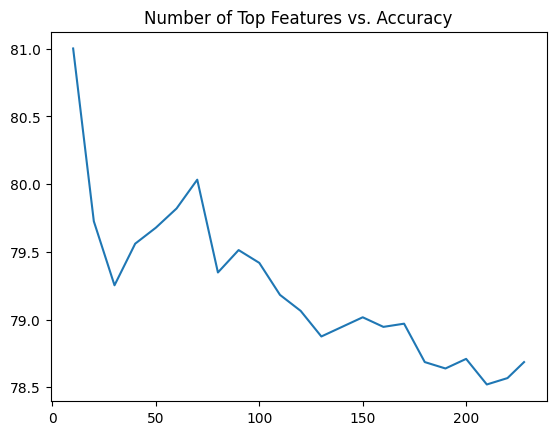

In [35]:
top = [10,20,30,40,50,60,70,80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 228]
acc = []

for t in top:
  cols = data_feat.Feature[0:t]
  train_feat = pd.DataFrame(train_encoded, columns=cols)
  train_feat = pd.concat([train_feat, train_encoded['DiagPeriodL90D']], axis = 1)
  clf = XGBClassifier(random_state=42)
  scaler = StandardScaler()
  #Model after removing correlations
  y_pred, accuracy, precision, recall, f1, auc = run_model(scaler, train_feat, clf)
  acc.append(accuracy*100)
  print(f'Accuracy of top {t} features selected is {round(accuracy, 3)*100}%')

plt.plot(top, acc)
plt.title('Number of Top Features vs. Accuracy')

Text(0.5, 1.0, 'Accuracy vs. Number of Top N features using an XGBClassifer')

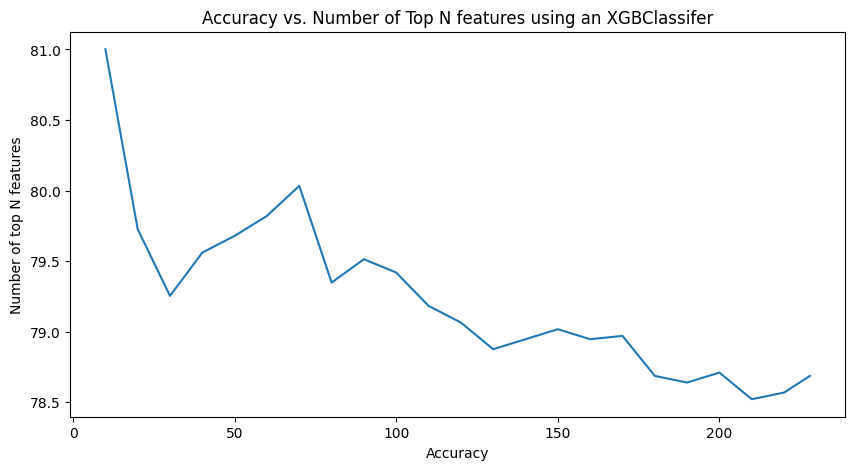

In [36]:
plt.figure(figsize = (10,5))
plt.plot(top, acc)
plt.xlabel('Accuracy')
plt.ylabel('Number of top N features')
plt.title('Accuracy vs. Number of Top N features using an XGBClassifer')

# Let's now use stratified cross validation to see if the accuracy averages out

In [ ]:
top = [10,20,30,40,50,60,70,80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 228]
acc = []

for t in top:
  cols = data_feat.Feature[0:t]
  train_feat = pd.DataFrame(train_encoded, columns=cols)
  train_feat = pd.concat([train_feat, train_encoded['DiagPeriodL90D']], axis = 1)

  clf = XGBClassifier(random_state=42)
  accuracy = model_cross_val(scaler, clf, train_feat)
  acc.append(accuracy*100)
  print(f'Accuracy of top {t} features selected is {round(accuracy*100,3)}%')

Accuracy of top 10 features selected is 80.94%
Accuracy of top 20 features selected is 80.122%
Accuracy of top 30 features selected is 79.864%
Accuracy of top 40 features selected is 79.88%
Accuracy of top 50 features selected is 80.052%
Accuracy of top 60 features selected is 79.989%
Accuracy of top 70 features selected is 79.786%
Accuracy of top 80 features selected is 79.662%
Accuracy of top 90 features selected is 79.794%
Accuracy of top 100 features selected is 79.537%
Accuracy of top 110 features selected is 79.365%
Accuracy of top 120 features selected is 79.521%
Accuracy of top 130 features selected is 79.576%
Accuracy of top 140 features selected is 79.529%
Accuracy of top 150 features selected is 79.677%
Accuracy of top 160 features selected is 79.233%
Accuracy of top 170 features selected is 79.56%
Accuracy of top 180 features selected is 79.077%
Accuracy of top 190 features selected is 79.279%
Accuracy of top 200 features selected is 79.342%
Accuracy of top 210 features sel

Text(0.5, 1.0, 'Accuracy vs. Number of Top N features using an XGBClassifer')

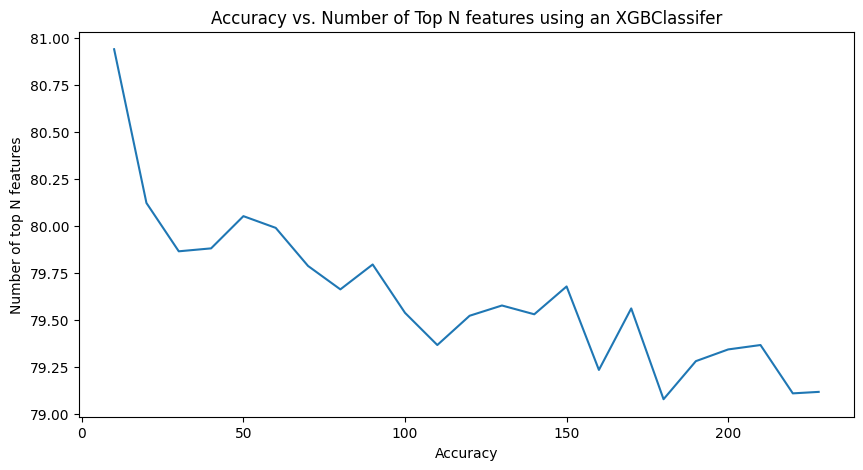

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(top, acc)
plt.xlabel('Accuracy')
plt.ylabel('Number of top N features')
plt.title('Accuracy vs. Number of Top N features using an XGBClassifer')

# Try Random Forest instead

Accuracy of top 10 features selected is 81.042%
Accuracy of top 20 features selected is 81.104%
Accuracy of top 30 features selected is 81.011%
Accuracy of top 40 features selected is 80.902%
Accuracy of top 50 features selected is 80.917%
Accuracy of top 60 features selected is 80.87%
Accuracy of top 70 features selected is 80.902%
Accuracy of top 80 features selected is 80.777%
Accuracy of top 90 features selected is 80.824%
Accuracy of top 100 features selected is 80.73%
Accuracy of top 110 features selected is 80.66%
Accuracy of top 120 features selected is 80.434%
Accuracy of top 130 features selected is 80.621%
Accuracy of top 140 features selected is 80.48%
Accuracy of top 150 features selected is 80.582%
Accuracy of top 160 features selected is 80.683%
Accuracy of top 170 features selected is 80.558%
Accuracy of top 180 features selected is 80.597%
Accuracy of top 190 features selected is 80.418%
Accuracy of top 200 features selected is 80.488%
Accuracy of top 210 features sele

Text(0.5, 1.0, 'Accuracy vs. Number of Top N features using an XGBClassifer')

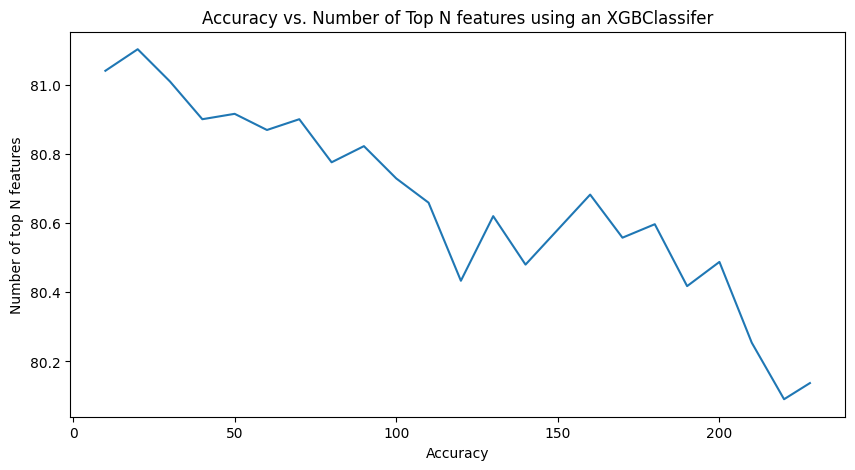

In [37]:
from sklearn.ensemble import RandomForestClassifier

top = [10,20,30,40,50,60,70,80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 228]
acc = []

for t in top:
  cols = data_feat.Feature[0:t]
  train_feat = pd.DataFrame(train_encoded, columns=cols)
  train_feat = pd.concat([train_feat, train_encoded['DiagPeriodL90D']], axis = 1)

  clf = RandomForestClassifier(max_depth=10, random_state=0)
  accuracy = model_cross_val(scaler, clf, train_feat)
  acc.append(accuracy*100)
  print(f'Accuracy of top {t} features selected is {round(accuracy*100,3)}%')

plt.figure(figsize = (10,5))
plt.plot(top, acc)
plt.xlabel('Accuracy')
plt.ylabel('Number of top N features')
plt.title('Accuracy vs. Number of Top N features using an XGBClassifer')

# Try Catboost

In [38]:
from catboost import CatBoostClassifier

In [ ]:
top = [10,20,30,40,50,60,70,80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 228]
acc = []

# Model için parametreler
params = {

    'depth':2,
    'random_state': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'loss_function': 'Logloss',
    'learning_rate':0.3,
    'iterations':1000
}

for t in top:
  cols = data_feat.Feature[0:t]
  train_feat = pd.DataFrame(train_encoded, columns=cols)
  train_feat = pd.concat([train_feat, train_encoded['DiagPeriodL90D']], axis = 1)

  clf = CatBoostClassifier(**params)
  accuracy = model_cross_val(scaler, clf, train_feat)
  acc.append(accuracy*100)
  print(f'Accuracy of top {t} features selected is {round(accuracy*100,3)}%')

plt.figure(figsize = (10,5))
plt.plot(top, acc)
plt.xlabel('Accuracy')
plt.ylabel('Number of top N features')
plt.title('Accuracy vs. Number of Top N features using an XGBClassifer')

Accuracy of top 10 features selected is 81.174%
Accuracy of top 20 features selected is 80.566%
Accuracy of top 30 features selected is 80.636%
Accuracy of top 40 features selected is 80.363%
Accuracy of top 50 features selected is 80.48%
Accuracy of top 60 features selected is 80.332%
Accuracy of top 70 features selected is 80.363%
